In [ ]:
pip install langgraph

In [12]:
def function_1(state):
    input_1 = state.get("input_1")
    return {"input_2": input_1 + " Hi"}

def function_2(state):
    input_2 = state.get("input_2")
    return input_2 + " there"

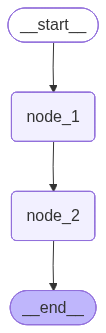

In [7]:
from langgraph.graph import StateGraph, END
from IPython.display import Image

workflow = StateGraph(dict)
workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge("node_1", "node_2")
workflow.add_edge("node_2", END)

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

Image(app.get_graph().draw_mermaid_png())

In [8]:
app.invoke({"input_1": "Hello"})

'Hello Hi there'

In [9]:
for output in app.stream({"input_1": "Hello"}):
    print(output)

{'node_1': {'input_2': 'Hello Hi'}}
{'node_2': 'Hello Hi there'}


In [13]:
for output in app.stream({"input_1": "Hello"}):
    for k,v in output.items():
        print(f"Ouput from node '{k}: ")
        print("---")
        print(v)

Ouput from node 'node_1: 
---
{'input_2': 'Hello Hi'}
Ouput from node 'node_2: 
---
Hello Hi there


In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini")

In [23]:
def function_1(state):
    input_1 = state.get("input_1")
    response = llm.invoke(input_1)
    return response.content


def function_2(state):
    return "Agent Says :: " + state

In [24]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(dict)
workflow.add_node("agent", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge("agent", "node_2")
workflow.add_edge("node_2", END)

workflow.set_entry_point("agent")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [25]:
for output in app.stream({"input_1": "Hello"}):
    for k,v in output.items():
        print(f"Ouput from node '{k}: ")
        print("---")
        print(v)

Ouput from node 'agent: 
---
Hello! How can I assist you today?
Ouput from node 'node_2: 
---
Agent Says :: Hello! How can I assist you today?


In [33]:
def function_1(state):
    input_1 = state.get("input_1")
    complete_query = f"Your task is to provide only the city name based on the user query. \
                        Nothing more, just the city name mentioned. Following is the user query: {input_1}"
    response = llm.invoke(complete_query)
    return response.content


def function_2(state):
    return "Agent Says :: " + state

In [34]:
function_1({"input_1": "I am in chennai"})

'Chennai'

In [ ]:
pip install pyowm

In [7]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper

weather = OpenWeatherMapAPIWrapper()
weather_data = weather.run("Chennai")
print(weather_data)

In Chennai, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 4.83 m/s, direction: 154°
Humidity: 76%
Temperature: 
  - Current: 28.5°C
  - High: 28.5°C
  - Low: 28.5°C
  - Feels like: 32.66°C
Rain: {}
Heat index: None
Cloud cover: 95%


In [9]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper

weather = OpenWeatherMapAPIWrapper()

def function_1(state):
    input_1 = state.get("input_1")
    complete_query = f"Your task is to provide only the city name based on the user query. \
                        Nothing more, just the city name mentioned. Following is the user query: {input_1}"
    response = llm.invoke(complete_query)
    return response.content


def function_2(state):
    return weather.run(state) 

In [10]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(dict)
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge("agent", "tool")
workflow.add_edge("tool", END)

workflow.set_entry_point("agent")
workflow.set_finish_point("tool")

app = workflow.compile()

In [12]:
for output in app.stream({"input_1": "What is temparature in chennai"}):
    for k,v in output.items():
        print(f"Ouput from node '{k}: ")
        print("---")
        print(v)

Ouput from node 'agent: 
---
Chennai
Ouput from node 'tool: 
---
In Chennai, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 4.83 m/s, direction: 154°
Humidity: 76%
Temperature: 
  - Current: 28.5°C
  - High: 28.5°C
  - Low: 28.5°C
  - Feels like: 32.66°C
Rain: {}
Heat index: None
Cloud cover: 95%


In [13]:
AgentState = {}
AgentState["messages"] = []

AgentState

{'messages': []}

In [2]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_openai import ChatOpenAI

def function_1(state):
    messages = state["messages"]
    user_input = messages[-1]
    complete_query = f"Your task is to provide only the city name based on the user query. \
                        Nothing more, just the city name mentioned. Following is the user query: {user_input}"
    response = llm.invoke(complete_query)
    state["messages"].append(response.content)
    return state

def function_2(state):
    messages = state["messages"]
    agent_response = messages[-1]
    weather = OpenWeatherMapAPIWrapper()
    weather_data = weather.run(agent_response)
    state["messages"].append(weather_data)
    return state 

def function_3(state):
    messages = state["messages"]
    user_input = messages[0]
    agent_response = messages[-1]
    llm = ChatOpenAI(model="gpt-4o-mini")
    
    complete_query = f"Your task is to provide info concisely based on the user query \
        and the available information. \
        Following is the user query: {user_input}, Available information: {agent_response}"
    response = llm.invoke(complete_query)
    return response.content    
    
    

In [3]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(dict)
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)
workflow.add_node("responder", function_3)

workflow.add_edge("agent", "tool")
workflow.add_edge("tool", "responder")
workflow.add_edge("responder", END)

workflow.set_entry_point("agent")
workflow.set_finish_point("responder")

app = workflow.compile()

In [4]:
inputs = {"messages": ["what is the humidity in chennai"]}

app.invoke(inputs)

'The current humidity in Chennai is 78%.'

In [6]:
from typing import TypedDict, Annotated
import operator

class AgentState(TypedDict):
    messages: Annotated[list, operator.add]

In [12]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_openai import ChatOpenAI

def function_1(state):
    messages = state["messages"]
    user_input = messages[-1]
    complete_query = f"Your task is to provide only the city name based on the user query. \
                        Nothing more, just the city name mentioned. Following is the user query: {user_input}"
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

def function_2(state):
    messages = state["messages"]
    agent_response = messages[-1]
    weather = OpenWeatherMapAPIWrapper()
    weather_data = weather.run(agent_response)
    return {"messages": [weather_data]}

def function_3(state):
    messages = state["messages"]
    user_input = messages[0]
    agent_response = messages[-1]
    llm = ChatOpenAI(model="gpt-4o-mini")
    
    complete_query = f"Your task is to provide info concisely based on the user query \
        and the available information. \
        Following is the user query: {user_input}, Available information: {agent_response}"
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}    
    
    

In [13]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(state_schema=AgentState)
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)
workflow.add_node("responder", function_3)

workflow.add_edge("agent", "tool")
workflow.add_edge("tool", "responder")
workflow.add_edge("responder", END)

workflow.set_entry_point("agent")
workflow.set_finish_point("responder")

app = workflow.compile()

In [14]:
inputs = {"messages": ["what is the humidity in chennai"]}

app.invoke(inputs)

{'messages': ['what is the humidity in chennai',
  'Chennai',
  'In Chennai, the current weather is as follows:\nDetailed status: overcast clouds\nWind speed: 4.11 m/s, direction: 168°\nHumidity: 77%\nTemperature: \n  - Current: 27.89°C\n  - High: 27.89°C\n  - Low: 27.89°C\n  - Feels like: 31.39°C\nRain: {}\nHeat index: None\nCloud cover: 98%',
  'The current humidity in Chennai is 77%.']}